In [54]:
import os
import itertools
import random
from math import log, exp, sqrt

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler


import matplotlib.animation as animation

import numpy as np
from scipy import stats
from numpy.linalg import norm

import ars

from BayesW_utils import *
from distributions import *

In [55]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black', 'blue', 'green'])))#, )))

# Sampling algorithm

## Init functions

In [56]:
n_markers, n_samples,n_covs = 15,100,10

In [57]:
mu_true = 5
alpha_true = 1
sigma_g_true = 0.5

data = simulate_data(mu_true = mu_true, 
                     alpha_true = alpha_true, 
                     sigma_g_true = sigma_g_true,
                     n_markers = n_markers,
                     n_samples = n_samples,
                     n_covs = n_covs,
                     prevalence = 1
                     )
markers, betas, cov, d_fail, y_data_log = data

In [58]:
norm_markers = helpers.normalize_markers(markers)

In [65]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                n_samples = n_samples,
                                                n_covs = n_covs,
                                                l_mix = 1, 
                                                data = data)

### Variance check up

In [66]:
print("Sample variance: ",np.var(y_data_log))
print("Phenotypic variance: ",sigma_g_true + np.pi**2/(6*alpha_true**2))

Sample variance:  1.9973216775109892
Phenotypic variance:  2.1449340668482266


In [7]:
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

In [67]:
pars["alpha"], pars["sigma_g"]

(0.9029585965525259, 2.017496643950494)

In [72]:
epsilon = y_data_log

In [63]:
pars["alpha"] = np.var(y_data_log)

### mu density checkup

In [79]:
-np.sum(np.exp((epsilon - np.mean(y_data_log))*pars['alpha'] -np.euler_gamma))

-120.57329471774122

In [86]:
pars["d"] = pars["d"]*n_samples

In [87]:
pars["alpha"]*pars["d"]*5 

451.4792982762629

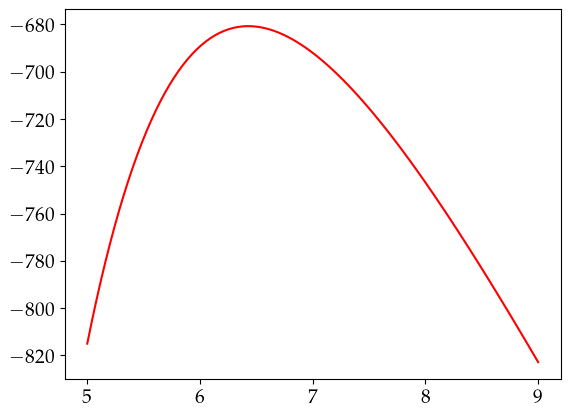

In [92]:
xplot = np.linspace(5,9,100)
f = [mu.f(pars, epsilon)(x) for x in xplot]
plt.plot(xplot,f)

In [51]:
pars["sigma_g"] = sigma_g_true
pars["alpha"] = alpha_true

In [18]:
pars

{'alpha': 0.7305795320386365,
 'sigma_g': 0.7379591232713499,
 'd': 100.0,
 'var_mu': 100,
 'var_delta': 100,
 'alpha_zero': 0.01,
 'kappa_zero': 0.01,
 'd_array': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'alpha_sigma': 1,
 'beta_sigma': 0.0001,
 'mixture_C_all': array([0.00066667, 0.00066667, 0.00066667, 0.00066667, 0.00066667,
        0.00066667, 0.00066667, 0.00066667, 0.00066667, 0.00066667,
        0.00066667, 0.00066667, 0.00066667, 0.00066667, 0.00066667]),
 'mixture_groups': 1,
 'mixture_component': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'sum_fail_all': array([ 1.33226763e-15,  4.66293670e-15,  5.88418203e-15, -7.18869408e-15,
         6.21724894e-15, 

In [25]:
pars["sigma_g"]

0.9354951530231246

### beta density checkup

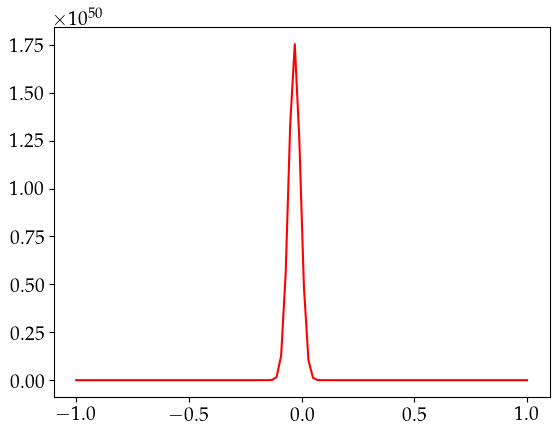

In [32]:
xplot = np.linspace(-1,1,100)
f = [betas[0].f(pars, partial_sums)(x) for x in xplot]
plt.plot(xplot,np.exp(f))


## Sampling no sigma_g

In [29]:
maxit = 100
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.7, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

epsilon = y_data_log - mu.now

N = len(y_data_log)

for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        else:
            epsilon = epsilon + norm_markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - norm_markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
    
    

it: 1/100
it: 2/100
it: 3/100
it: 4/100
it: 5/100
it: 6/100
it: 7/100
it: 8/100
it: 9/100
it: 10/100
it: 11/100
it: 12/100
it: 13/100
it: 14/100
it: 15/100
it: 16/100
it: 17/100
it: 18/100
it: 19/100
it: 20/100
it: 21/100
it: 22/100
it: 23/100
it: 24/100
it: 25/100
it: 26/100
it: 27/100
it: 28/100
it: 29/100
it: 30/100
it: 31/100
it: 32/100
it: 33/100
it: 34/100
it: 35/100
it: 36/100
it: 37/100
it: 38/100
it: 39/100
it: 40/100
it: 41/100
it: 42/100
it: 43/100
it: 44/100
it: 45/100
it: 46/100
it: 47/100
it: 48/100
it: 49/100
it: 50/100
it: 51/100
it: 52/100
it: 53/100
it: 54/100
it: 55/100
it: 56/100
it: 57/100
it: 58/100
it: 59/100
it: 60/100
it: 61/100
it: 62/100
it: 63/100
it: 64/100
it: 65/100
it: 66/100
it: 67/100
it: 68/100
it: 69/100
it: 70/100
it: 71/100
it: 72/100
it: 73/100
it: 74/100
it: 75/100
it: 76/100
it: 77/100
it: 78/100
it: 79/100
it: 80/100
it: 81/100
it: 82/100
it: 83/100
it: 84/100
it: 85/100
it: 86/100
it: 87/100
it: 88/100
it: 89/100
it: 90/100
it: 91/100
it: 92/1

Text(0.5, 1.0, '$\\sigma_G^2$')

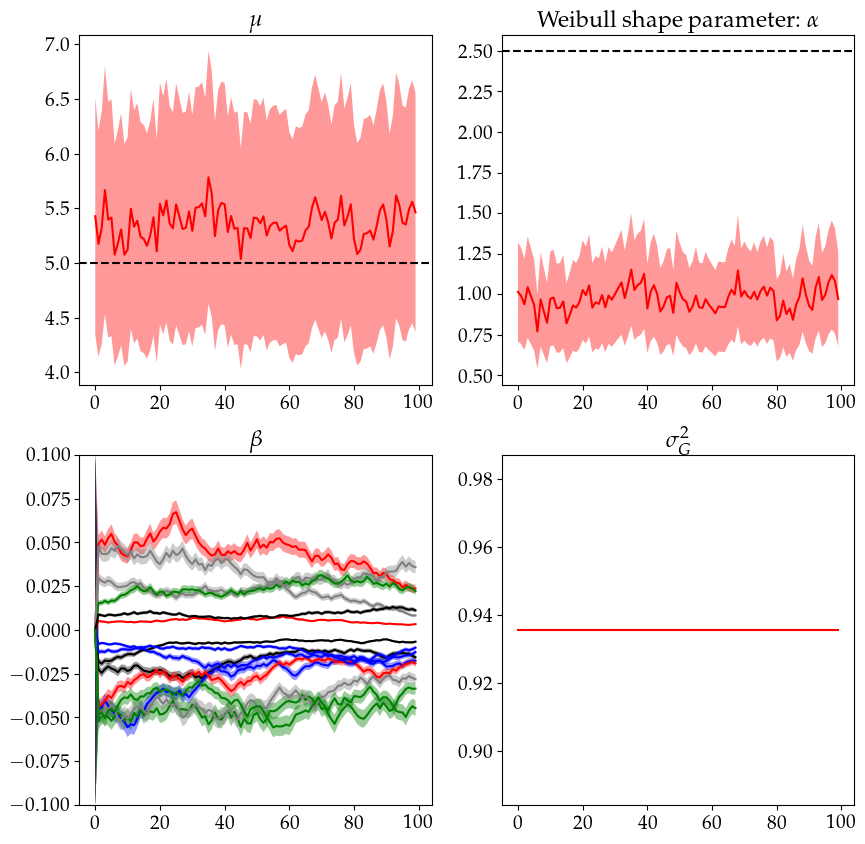

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
#plt.plot(np.repeat(pars["alpha"], 100))
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
plt.ylim(-0.1, 0.1)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
plt.plot(np.repeat(pars["sigma_g"], 100))
#sigma_g.plot_sampled_values()
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

## Sampling with real sigmaG value

In [34]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                n_samples = n_samples,
                                                n_covs = n_covs,
                                                l_mix = 1, 
                                                data = data)

In [38]:
pars["alpha"] = np.var(y_data_log)

In [35]:
pars["sigma_g"] = sigma_g_true

In [39]:
maxit = 100
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.7, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

epsilon = y_data_log - mu.now

N = len(y_data_log)

for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        else:
            epsilon = epsilon + norm_markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - norm_markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
    

it: 1/100
it: 2/100
it: 3/100
it: 4/100
it: 5/100
it: 6/100
it: 7/100
it: 8/100
it: 9/100
it: 10/100
it: 11/100
it: 12/100
it: 13/100
it: 14/100
it: 15/100
it: 16/100
it: 17/100
it: 18/100
it: 19/100
it: 20/100
it: 21/100
it: 22/100
it: 23/100
it: 24/100
it: 25/100
it: 26/100
it: 27/100
it: 28/100
it: 29/100
it: 30/100
it: 31/100
it: 32/100
it: 33/100
it: 34/100
it: 35/100
it: 36/100
it: 37/100
it: 38/100
it: 39/100
5.57271711244858 (4.458173689958865, 6.687260534938296)


/home/avillanu/GitHub/BayesW/ars.py:168: RuntimeWarning: invalid value encountered in divide
  probs = probs/np.sum(probs)


ValueError: Something in the sampler went wrong

In [40]:
pars["alpha"]

1.243002401508449

The error occurs because alpha is too big...

Text(0.5, 1.0, '$\\sigma_G^2$')

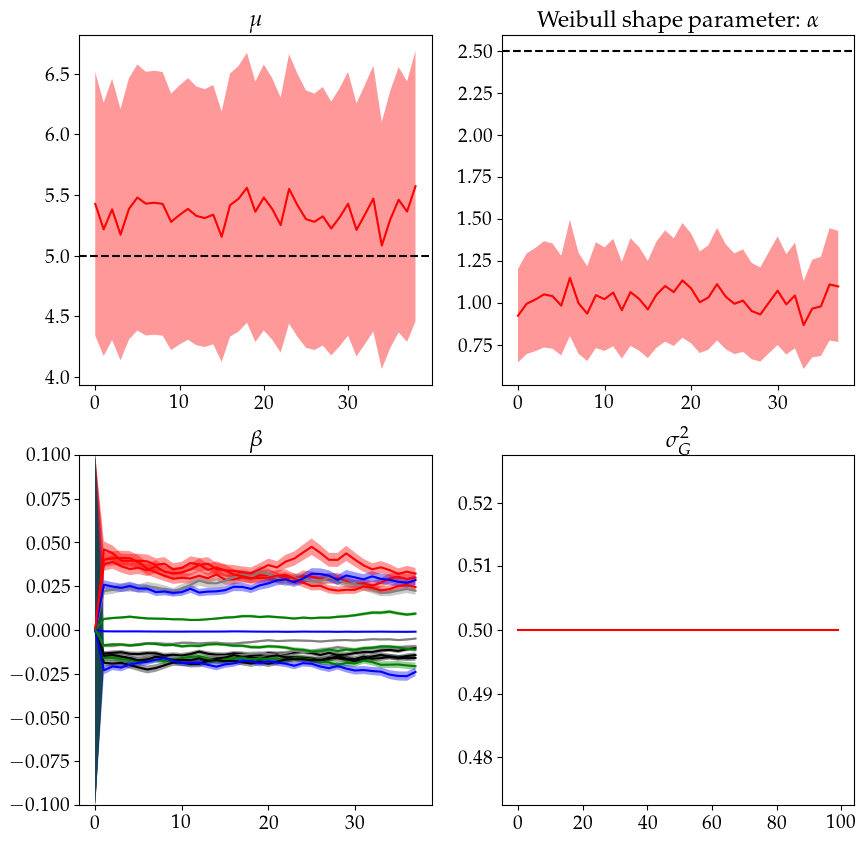

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
#plt.plot(np.repeat(pars["alpha"], 100))
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
plt.ylim(-0.1, 0.1)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
plt.plot(np.repeat(pars["sigma_g"], 100))
#sigma_g.plot_sampled_values()
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

## Sampling all

In [51]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                n_samples = n_samples,
                                                n_covs = n_covs,
                                                l_mix = 1, 
                                                data = data)

In [47]:
pars["alpha"] = np.var(y_data_log)

In [52]:
pars["sigma_g"]

0.9354951530231246

In [48]:
maxit = 100
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.7, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

sigma_g = SimpleParameter(pars["sigma_g"])

epsilon = y_data_log - mu.now

num_samples = 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))

    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        else:
            epsilon = epsilon + markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
    
    
    sigma_g.sample_posterior(sigma_g_func(betas, pars))
    pars["sigma_g"] = sigma_g.now

it: 1/100
it: 2/100


/home/avillanu/GitHub/BayesW/ars.py:134: RuntimeWarning: overflow encountered in exp
  probs = np.exp(dhdxs * limits[:, 1] + c) - np.exp(dhdxs * limits[:, 0] + c)


it: 3/100
it: 4/100
it: 5/100
it: 6/100
it: 7/100
it: 8/100
it: 9/100
it: 10/100
it: 11/100
it: 12/100
it: 13/100
it: 14/100
it: 15/100
it: 16/100
it: 17/100
it: 18/100
it: 19/100
it: 20/100
it: 21/100
it: 22/100
it: 23/100
it: 24/100
it: 25/100
it: 26/100
it: 27/100
it: 28/100
5.5522046301588635 (4.441763704127091, 6.662645556190636)


/home/avillanu/GitHub/BayesW/ars.py:168: RuntimeWarning: invalid value encountered in divide
  probs = probs/np.sum(probs)


ValueError: Something in the sampler went wrong

Text(0.5, 1.0, '$\\sigma_G^2$')

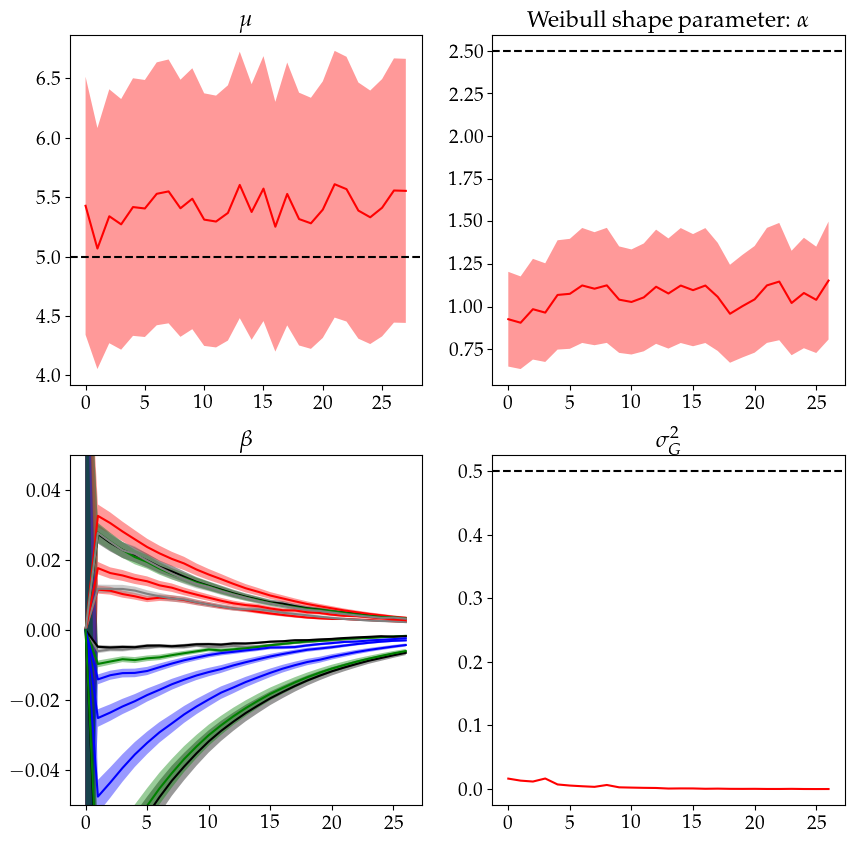

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
plt.ylim(-0.05, 0.05)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
sigma_g.plot_sampled_values(truth = sigma_g_true)
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

In [13]:
'''Defined posterior of sigma_g parameter'''
betas_arr = np.array([beta.now for beta in betas])
_, gamma_k = np.unique(pars["mixture_component"], return_counts=True)
betas_sqr = []
for k in range(1, pars["mixture_groups"]+1):
    b = betas_arr[pars["mixture_component"] == k]
    betas_sqr = b.T.dot(b)

alpha = pars["alpha_sigma"] + 0.5 * np.sum(gamma_k)
beta = pars["beta_sigma"] + 0.5 * np.sum(gamma_k*betas_sqr)

In [3]:
#data
n_markers = 200 #number M of markers
n_samples = 100 #number of individuals (times to event)
n_covs = 10 #number of covariates
l_mix = 4 #mixture components
max_iter = 1000

#simulated data
markers = np.random.binomial(2, 0.5, size = (n_samples, n_markers)) #x matrix of markers
cov = np.random.binomial(1, 0.5, size = (n_samples, n_covs)) #z matrix of 

d_fail = np.ones(n_samples)

In [4]:
pars = {}

In [5]:
weibull_pars = (np.random.uniform(), np.random.uniform())
pars["gumbel_loc"] = -log(weibull_pars[1])
pars["gumbel_scale"] = 1/weibull_pars[0]

gumbel_dis = stats.gumbel_r(loc=pars["gumbel_loc"], scale=pars["gumbel_scale"])

In [6]:
y_data_log = gumbel_dis.rvs(size=100)
mu = np.mean(y_data_log)
residuals = y_data_log - mu

In [7]:
#initial values
betas = np.zeros(n_markers)
deltas = np.zeros(n_covs)
gammas = np.zeros(n_markers)
mu = np.mean(y_data_log)

alpha_ini = np.pi/sqrt( 6*np.sum( (y_data_log-mu) **2) / (len(y_data_log)-1))
sigma_g = np.var(y_data_log)/n_markers
d = np.sum(d_fail)

In [8]:
#priors of parameters
alpha_zero = 0.01
kappa_zero = 0.01
alpha_sigma = 1
beta_sigma = 0.0001
var_mu = 100
var_delta = 100
pi_vector = np.zeros(l_mix) + 1
hyperparameters = np.zeros(l_mix +1)

In [9]:
pars = {"alpha": alpha_ini, 
        "d": d, 
        "var_mu": var_mu, 
        "alpha_zero": alpha_zero,
        "kappa_zero": kappa_zero, 
        "d_array": d_fail}

In [10]:
pars

{'alpha': 0.8134552216974429,
 'd': 100.0,
 'var_mu': 100,
 'alpha_zero': 0.01,
 'kappa_zero': 0.01,
 'd_array': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [11]:
residuals = y_data_log - mu
epsilon = residuals + mu

In [12]:
from distributions import *

In [13]:
class Parameter:
    def __init__(self, log_dens_f, dev_log_dens, bounds, init_value, sampler_x0 = 1):
        self.current_value = init_value
        self.init_value = init_value
        self.previous_values = []
        self.f = log_dens_f
        self.df = dev_log_dens
        self.bounds = bounds
        self.now = init_value
        self.sampler_x0 = sampler_x0


    def get_bounds(self):
        
        val_bounds = self.bounds
        bounds = (val_bounds[0]*self.current_value, val_bounds[1]*self.current_value)

        if helpers.bounds_error(bounds):
            return (self.bounds[0] - 1, self.bounds[1] - 1)
        else:
            return bounds
    
    def get_value(self):
        return self.current_value
    
    def sample_posterior(self, params, epsilon_or_sums, n_samples=1):

        bounds = self.get_bounds()
        self.previous_values.append(self.current_value)
        samples, xs = ars.adaptive_rejection_sampling(x0=self.now*self.sampler_x0, 
                                                      log_unnorm_prob=self.f(params, epsilon), 
                                                      derivative= self.df(params, epsilon), 
                                                      num_samples=n_samples, bounds=bounds)
        
        if n_samples == 1:
            self.current_value = samples[0]
        else:
            self.current_value = samples

        return self.current_value
    
    def plot_sampled_values(self, truth = None):
        bounds = np.array([np.array([0.9*i, 1.1*i]) for i in self.previous_values])
        plt.plot(self.previous_values)
        if truth != None:
            plt.axhline(y=truth, linestyle= "--", color="k")
        plt.fill_between(range(0,len(self.previous_values)), y1=bounds[:,0], y2=bounds[:,1], alpha=0.4)
    
    def likelihood(self, data):
        """"""
    def log_prior(self):
        """"""

In [14]:
maxit = 100

## our start guess is mu
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.1, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

epsilon = y_data_log - mu.now

num_samples = 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)

    pars["alpha"] = alpha.now

NameError: name 'helpers' is not defined

In [48]:
xs, hs, dhdxs = ars.initialise_abcissa(mu.now*mu.sampler_x0, mu.f(pars, epsilon), mu.df(pars,epsilon), 100,mu.get_bounds())

In [49]:
xs

array([4.36199581, 4.37644741, 4.39290052, 4.41454215, 4.44143772,
       4.45775741, 4.45801756, 4.48831291, 4.51075153, 4.51905274,
       4.52885654, 4.56284234, 4.56664218, 4.57248353, 4.61824455,
       4.6276618 , 4.67255961, 4.70966321, 4.7197593 , 4.72261328,
       4.75354382, 4.79495609, 4.79999275, 4.87482048, 4.8785586 ,
       4.9681159 , 4.98402352, 5.02337845, 5.03679874, 5.04762745,
       5.05913474, 5.10070181, 5.11213301, 5.13296281, 5.1582399 ,
       5.17401191, 5.19141246, 5.22192406, 5.2311501 , 5.31295329,
       5.32673087, 5.33501305, 5.357415  , 5.38764183, 5.38849252,
       5.3906781 , 5.40455962, 5.41358825, 5.41539814, 5.43149727,
       5.43179722, 5.44030565, 5.45242376, 5.45671916, 5.46057861,
       5.46714985, 5.47765573, 5.55143318, 5.62222147, 5.6553365 ,
       5.67842477, 5.70402899, 5.73144304, 5.76216407, 5.79912099,
       5.81252799, 5.83336243, 5.84167168, 5.88227296, 5.88609727,
       5.88770382, 5.90544319, 5.93133928, 5.93846085, 5.96449

In [50]:
z, c = ars.compute_points_of_intersection_and_intercepts(xs, hs, dhdxs)

In [51]:
limits, probs = ars.envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)

In [55]:
limits[-1]

array([6.88238843, 8.45242376])

In [61]:
i = -1

In [60]:
u = np.random.uniform()

In [62]:
np.log(u * np.exp(dhdxs[i] * limits[i, 1]) + (1 - u) * np.exp(dhdxs[i] * limits[i, 0]))


-11.131646480566285

In [64]:
bounds = mu.get_bounds()

In [66]:
limits, all_probs = ars.envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)

if bounds[0] > bounds[1]:
    bounds = helpers.change_order(bounds)
    
include = helpers.find_positions_between_limits(limits, bounds)

probs = np.zeros(len(all_probs))
probs[include] = all_probs[include]
probs = helpers.normalize_probabilities(probs)

if len(include) == 0:
    print(limits)

if np.any(probs < 0):
    print(bounds, probs[probs < 0], xs[probs < 0])

probs = probs/np.sum(probs)

# Randomly chosen interval in which the sample lies
i = np.random.choice(np.arange(probs.shape[0]), p=probs)

# Sample u = Uniform(0, 1)
u = np.random.uniform()

# Invert i^th piecewise exponential CDF to get a sample from that interval
 

x = np.logaddexp(dhdxs[i] * limits[i, 1], np.log(u) + np.log(np.exp(dhdxs[i] * (limits[i, 0] - limits[i, 1])) + 1 - uw))
x = x / dhdxs[i] 


/tmp/ipykernel_19008/2619082410.py:29: RuntimeWarning: overflow encountered in exp
  x = np.log(u * np.exp(dhdxs[i] * limits[i, 1]) \
/tmp/ipykernel_19008/2619082410.py:30: RuntimeWarning: overflow encountered in exp
  + (1 - u) * np.exp(dhdxs[i] * limits[i, 0]))


In [69]:
limits[i,1]

6.486819530395344

In [63]:
ars.sample_envelope(xs, hs, dhdxs, mu.get_bounds())

/home/avillanu/GitHub/BayesW/ars.py:181: RuntimeWarning: overflow encountered in exp
  x = np.log(u * np.exp(dhdxs[i] * limits[i, 1]) \
/home/avillanu/GitHub/BayesW/ars.py:182: RuntimeWarning: overflow encountered in exp
  + (1 - u) * np.exp(dhdxs[i] * limits[i, 0]))


inf

In [24]:
lims = (min(xs), max(xs))
    
# Compute the points of intersection of the lines making up the envelope
z, c = ars.compute_points_of_intersection_and_intercepts(xs, hs, dhdxs)

# Left-right endpoints for each piece in the piecewise envelope
limits = np.concatenate([[lims[0]], z, [lims[1]]])
limits = np.stack([limits[:-1], limits[1:]], axis=-1)
probs = []
for limit in limits:
    try:
        probs.append(np.exp(dhdxs * limits[:, 1] + c) - np.exp(dhdxs * limits[:, 0] + c))
    
    except:

        print("Error ocurred! ", limit)
        probs.append(0)

probs = np.array(probs)

# Catch any intervals where dhdx was zero
idx_nonzero = np.where(dhdxs != 0.)[0]
probs[idx_nonzero] = probs[idx_nonzero] / dhdxs[idx_nonzero]

idx_zero = np.where(dhdxs == 0.)[0]
if len(idx_zero) != 0:
    try:
        probs[idx_zero] = ((limits[:, 1] - limits[:, 0]) * np.exp(c))[idx_zero]
    except:
        print("Error ocurred! ", limits[idx_zero])
        probs[idx_zero] = 0 
    


Text(0.5, 1.0, '$\\mu$')

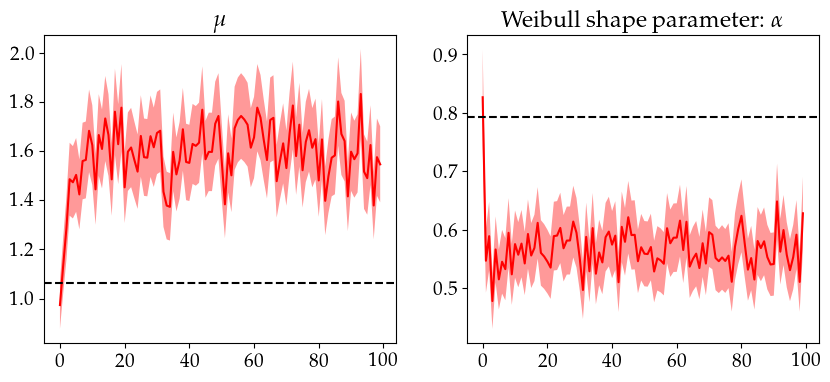

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
alpha.plot_sampled_values(truth = weibull_pars[0])
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(1,2,1)
mu.plot_sampled_values(truth = gumbel_dis.mean())
plt.title(r"$\mu$")

In [30]:
def calculate_exp_epsilon(pars, epsilon):
    return np.exp(pars["alpha"]*epsilon - np.euler_gamma)

In [16]:
exp_epsilon = calculate_exp_epsilon(pars, epsilon)

In [19]:
def log_beta(pars, partial_sums):
    '''computes the log-likelihood of the betas'''
    return lambda x: - pars["alpha"]*x*pars["sum_fail"] \
            + np.exp(pars["alpha"]*pars["mean_sd_ratio"]*x) \
            * (partial_sums[0] + partial_sums[1]*np.exp(-pars["alpha"]*x/pars["sd"]) + partial_sums[2]*np.exp(-2*pars["alpha"]*x/pars["sd"])) \
            - x**2/(2*pars["mixture_C"]*pars["sigma_g"])

In [17]:
mixture_C = np.ones(n_markers)
mixture_C = mixture_C*0.001
pars["mixture_C_all"] = mixture_C

In [18]:
pars["sigma_g"] = sigma_g

In [19]:
pars["sum_fail_all"] = (d_fail * markers.T).sum(axis=1)

In [20]:
sd_markers = np.std(markers, axis=0)
mean_markers = np.mean(markers, axis=0)
mean_sd_ratio = mean_markers/sd_markers

In [21]:
pars["mean_sd_ratio_all"] = mean_sd_ratio
pars["sd_all"] = sd_markers

In [25]:
def prepare_pars_for_beta(pars,j):
    pars['mean_sd_ratio'] = pars['mean_sd_ratio_all'][j]
    pars['sd'] = pars['sd_all'][j]
    pars['sum_fail'] = pars['sum_fail_all'][j]
    pars['mixture_C'] = pars['mixture_C_all'][j]
    return pars


In [22]:
def compute_partial_sums(exp_epsilon, marker):
    total_sum = exp_epsilon.sum()
    partial_sums = np.zeros(3)
    for i in [2,1]:
        idx = np.argwhere(marker == i)
        partial_sums[i] = exp_epsilon[idx].sum()
    
    partial_sums[0] = total_sum - partial_sums.sum()

    return partial_sums

In [23]:
partial_sums = compute_partial_sums(exp_epsilon, markers[:,0])

In [26]:
def dev_log_beta(pars, partial_sums):
    '''computes the first derivative of the log-likelihood of the betas'''
    return lambda x: -pars["alpha"]*pars["sum_fail"] \
            + pars["alpha"]*pars["mean_sd_ratio"]*np.exp(pars["alpha"]*pars["mean_sd_ratio"]*x) \
            * (partial_sums[0] + partial_sums[1]*np.exp(-pars["alpha"]*x/pars["sd"]) + partial_sums[2]*np.exp(-2*pars["alpha"]*x/pars["sd"])) \
            +  np.exp(pars["alpha"]*pars["mean_sd_ratio"]*x) \
            * (partial_sums[1]*np.exp(-pars["alpha"]*x/pars["sd"])*(-pars["alpha"]/pars["sd"]) + partial_sums[2]*np.exp(-2*pars["alpha"]*x/pars["sd"])*(-2*pars["alpha"]/pars["sd"])) \
            - x/(pars["mixture_C"]*pars["sigma_g"])

In [31]:
import helpers

In [26]:
pars = prepare_pars_for_beta(pars, 0)
df_beta = dev_log_beta(pars, partial_sums)

In [28]:
betas = list(betas)
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

In [37]:
maxit = 100

## our start guess is mu
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.1, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(betas)
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

epsilon = y_data_log - mu.now

num_samples = 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_epsilon, markers[:,j])
        else:
            epsilon = epsilon + markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_epsilon, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
        
    pars["alpha"] = alpha.now

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 1.0, '$\\beta$')

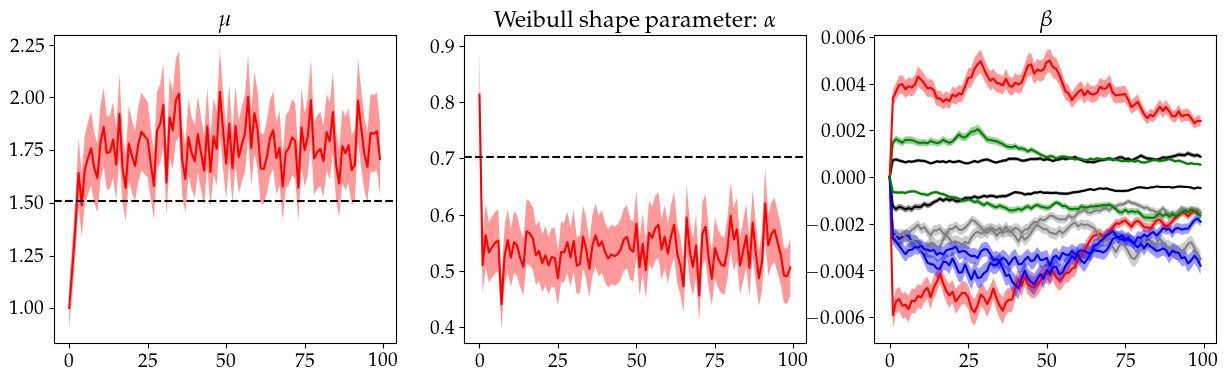

In [40]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,2)
alpha.plot_sampled_values(truth = weibull_pars[0])
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(1,3,1)
mu.plot_sampled_values(truth = gumbel_dis.mean())
plt.title(r"$\mu$")

plt.subplot(1,3,3)
for beta in betas[:10]:
    beta.plot_sampled_values()
plt.title(r"$\beta$")

In [31]:
import helpers

In [75]:
beta = betas[0]

In [48]:
xs, hs, dhdxs = ars.initialise_abcissa(beta.now*beta.sampler_x0, beta.f(pars, partial_sums), beta.df(pars,partial_sums), 100, beta.get_bounds())

In [49]:
z, c = ars.compute_points_of_intersection_and_intercepts(xs, hs, dhdxs)

In [50]:
limits, probs = ars.envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)

In [57]:
beta.get_bounds()

(0.0, 0.0)

In [56]:
helpers.find_positions_between_limits(limits, beta.get_bounds())

array([], dtype=int64)

In [13]:
f_mu = log_mu(pars, epsilon)
df_mu = dev_log_mu(pars, epsilon)

Log probability, is it log-concave?

In [14]:
pars["d"] = 100
pars

{'alpha': 0.28860764196553496, 'd': 100, 'var_mu': 100}

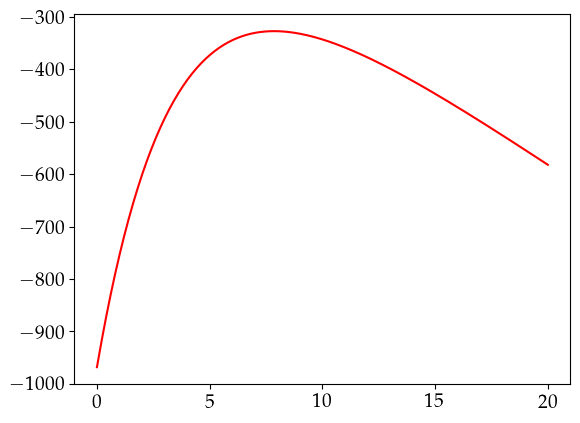

In [15]:
x_arr = np.linspace(0,20,200)
probs = [f_mu(x) for x in x_arr]
plt.plot(x_arr, probs)

It is !

Now, does it look approximately normally distributed?

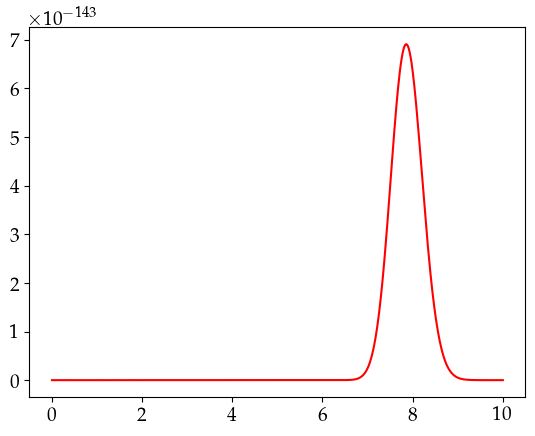

In [16]:
x_arr = np.linspace(0,10,500)
probs = [np.exp(f_mu(x)) for x in x_arr]
plt.plot(x_arr, probs)

It does! (not normalized)

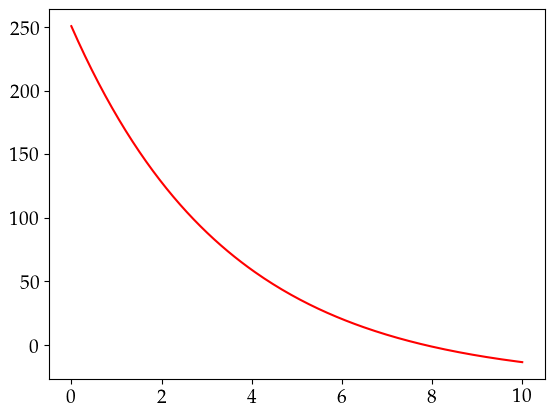

In [17]:
x_arr = np.linspace(0,10,200)
dprobs = [df_mu(x) for x in x_arr]
plt.plot(x_arr, dprobs)

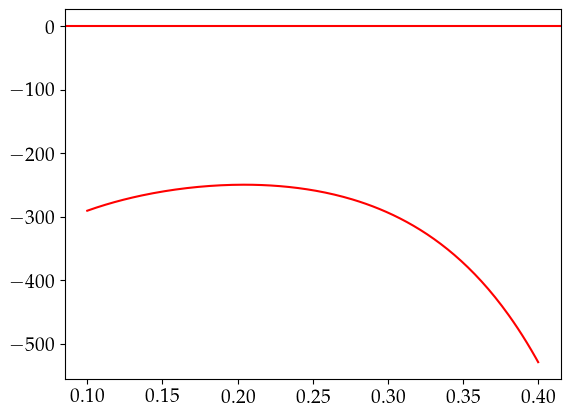

In [142]:
x_arr = np.linspace(0.1,0.4,200)
probs = [log_alpha(pars, epsilon)(x) for x in x_arr]
plt.plot(x_arr, probs)
plt.axhline(y=0)


## Parameter space for sampling $\mu$

In [19]:
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

In [20]:
pars["alpha"] = alpha

In [21]:
z =[]
try_pars = pars
for di in np.linspace(0,100,51):
    try_pars["d"] = di
    for var_i in np.linspace(1,100):
        try_pars["var_mu"] = var_i
        x_arr = np.linspace(0,10,200)
        probs = [mu.f(try_pars, epsilon)(x) for x in x_arr]
        max_x = x_arr[np.argmax(probs)]
        z.append(max_x)

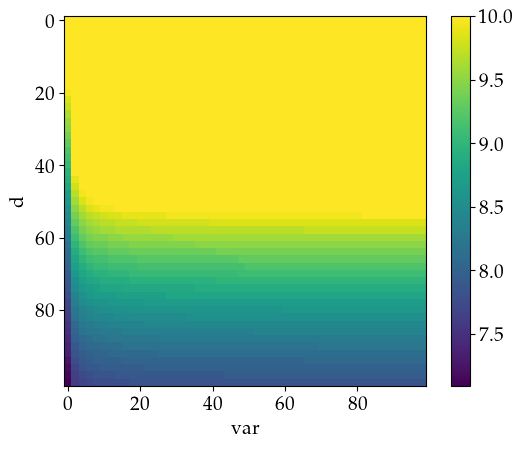

In [22]:
z_matrix = np.array(z).reshape(51,50)
fig, ax = plt.subplots(1,1)
img = ax.imshow(z_matrix)
ax.set_xlabel("var")
ax.set_ylabel("d")
ax.set_xticks([0,10,20,30,40])
ax.set_xticklabels(["0","20","40","60","80"])
ax.set_yticks([0,10,20,30,40])
ax.set_yticklabels(["0","20","40","60","80"])
fig.colorbar(img)

The variance does not really change where the maximum value of the function is...

In [23]:
pars["var_mu"] = 100

In [24]:
z =[]
try_pars = pars
for di in np.linspace(0,100, 51):
    try_pars["d"] = di
    for a_i in np.linspace(0,1):
        try_pars["alpha"] = a_i
        x_arr = np.linspace(0,10,200)
        probs = [mu.f(try_pars, epsilon)(x) for x in x_arr]
        max_x = x_arr[np.argmax(probs)]
        z.append(max_x)

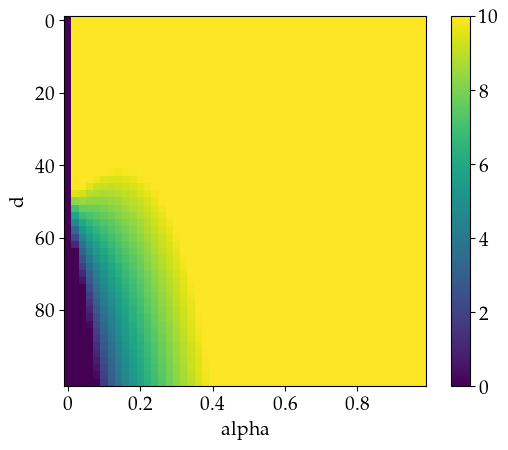

In [25]:
z_matrix = np.array(z).reshape(51,50)
fig, ax = plt.subplots(1,1)
img = ax.imshow(z_matrix)
ax.set_xlabel("alpha")
ax.set_ylabel("d")
ax.set_xticks([0,10,20,30,40])
ax.set_xticklabels(["0","0.2","0.4","0.6","0.8"])
ax.set_yticks([0,10,20,30,40])
ax.set_yticklabels(["0","20","40","60","80"])
fig.colorbar(img)

In [26]:
pars["alpha"] = alpha
pars["d"] = 100
epsilon = y_data_log

In [27]:
pars

{'alpha': 0.28860764196553496, 'd': 100, 'var_mu': 100}

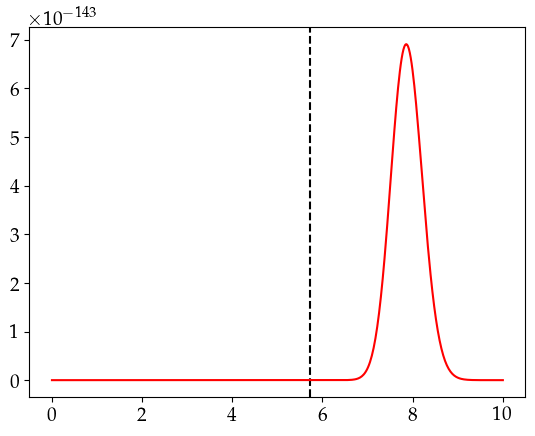

In [28]:
x_arr = np.linspace(0,10,500)
probs = [np.exp(mu.f(pars, epsilon)(x)) for x in x_arr]
plt.axvline(x = gumbel_dis.mean(), color="k", linestyle="--")
plt.plot(x_arr, probs)

In [29]:
pars["d"] = d

In [30]:
maxit = 100

## our start guess is mu
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

epsilon = y_data_log - mu.now

x0, num_samples = mu.now, 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

In [31]:
bounds = np.array([np.array([0.9*m, 1.1*m]) for m in mu.previous_values])

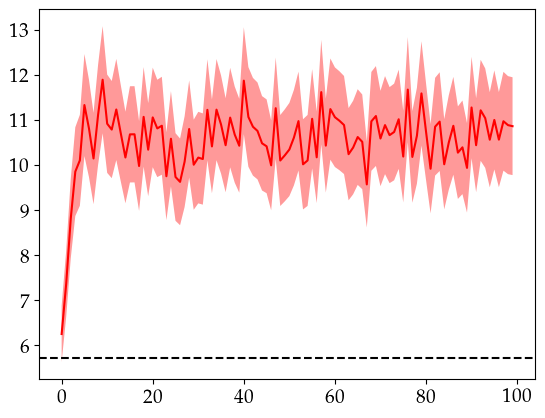

In [32]:
plt.close()
plt.plot(mu.previous_values)
plt.axhline(y=gumbel_dis.mean(), linestyle= "--", color="k")
plt.fill_between(range(0,maxit), y1=bounds[:,0], y2=bounds[:,1], alpha=0.4)
plt.show()


In [33]:
pars["d"] = 100

maxit = 100

## our start guess is mu
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

epsilon = y_data_log - mu.now

x0, num_samples = mu.now, 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

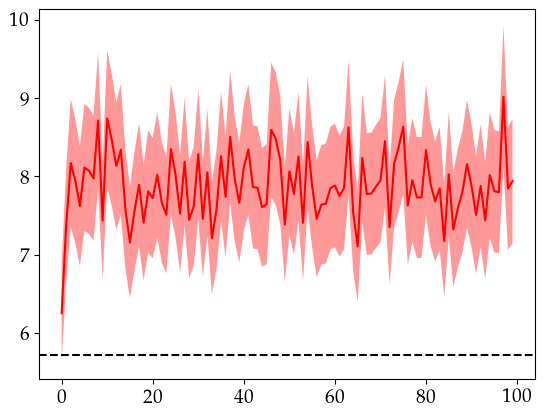

In [34]:
mu.plot_sampled_values()

In [35]:
pars

{'alpha': 0.28860764196553496, 'd': 100, 'var_mu': 100}

In [50]:
pars["d"] = 180

maxit = 100

## our start guess is mu
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

epsilon = y_data_log - mu.now

x0, num_samples = mu.now, 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

ValueError: probabilities contain NaN

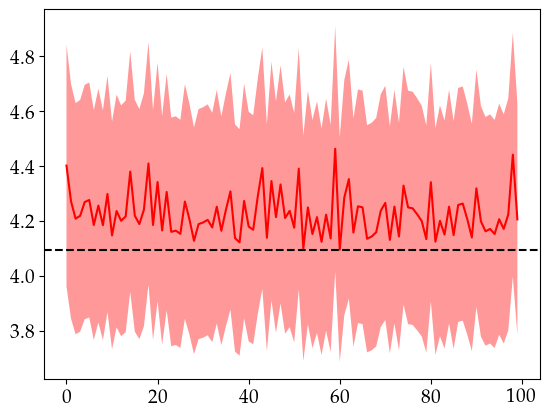

In [49]:
mu.plot_sampled_values()

In [110]:
pars

{'alpha': 0.39177982358408564, 'd': 220, 'var_mu': 100}